#### 1. A. What is the business objective you are looking to solve for? Specifically. 

 The primary business objective is to identify which customers would benefit the most from US Foods' 
 daily delivery service. This service comes at an increased operational cost, so it's essential to 
 target customers who are not only willing to but will also find substantial value in using this service, 
 thereby increasing their loyalty and lifetime value.

#### 1. B. What decisions are you going to inform?  

 Decisions to be Informed:
 
 Identification of customer segments that would most benefit from daily delivery service.
 Optimal pricing strategies for this enhanced service to ensure profitability.
 Inventory and supply chain adjustments needed to accommodate daily deliveries.

 #### 2. Which variable/s would you select as independent/dependent variables? And why? 

##### Scenario 1: Predicting Customer Spending with US Foods
Dependent Variable: REPORTED_WKLY_SPEND_USF (How much do you spend each week with US Foods)

Independent Variables: REPORTED_WKLY_SPEND, SMALL_QTY_RANK, DEL_FLEX_RANK, CUT_TIME_RANK, WKLY_ORDERS, PERC_EB, MENU_TYP_DESC, PYR_SEG_CD, AVG_WKLY_SALES, AVG_WKLY_CASES

Why: The goal here is to understand how various factors affect a customer's weekly spending with US Foods specifically. Independent variables are chosen based on their potential to influence the dependent variable.

##### Scenario 2: Predicting Importance of Flexible Delivery Schedule
Dependent Variable: DEL_FLEX_RANK (How important is having a flexible delivery schedule)

Independent Variables: REPORTED_WKLY_SPEND, REPORTED_WKLY_SPEND_USF, WKLY_ORDERS, MENU_TYP_DESC, PYR_SEG_CD

Why: Here, we want to understand what types of customers find a flexible delivery schedule to be most important. Therefore, we choose variables that could potentially affect this preference.

##### Scenario 3: Predicting Overall Weekly Spending with All Distributors
Dependent Variable: REPORTED_WKLY_SPEND (How much do you spend each week with all distributors)

Independent Variables: REPORTED_WKLY_SPEND_USF, REPORTED_WKLY_SPEND_COMP, WKLY_ORDERS, PERC_EB, MENU_TYP_DESC, PYR_SEG_CD, AVG_WKLY_SALES, AVG_WKLY_CASES

Why: The aim is to predict how much a customer will spend in total each week with all distributors. Independent variables are selected based on their likely impact on total weekly spending.

##### Scenario 4: Predicting Spending on Produce
Dependent Variable: REPORTED_PRODUCE_SPEND (How much of your purchasing in dollars with all sellers is Produce)

Independent Variables: REPORTED_WKLY_SPEND, REPORTED_WKLY_SPEND_USF, MENU_TYP_DESC, PYR_SEG_CD, AVG_WKLY_SALES, AVG_WKLY_CASES

Why: The goal is to understand what factors influence spending on produce. Variables related to overall spending and type of restaurant could be key drivers.

#### 3. What kind of feature engineering did you (or would you) try on these variables? 

Aggregation: Create new features that aggregate spends across various suppliers to get a holistic picture.

Encoding: One-hot or label encode categorical features like MENU_TYP_DESC.

Normalization/Standardization: As the scales of the features might differ, normalizing them could be beneficial.

Interaction Terms: Create interaction features that combine two or more features, which might provide additional insights.

#### 4. Choose a model that you believe best fits the dataset. Why did you choose this model? 

I would initially try a Random Forest Classifier for this task because:

It handles a mix of numerical and categorical features well.
It is less prone to overfitting compared to decision trees.
Feature importance can be easily extracted.

#### 5. Explain the accuracy of your model. Along with the explanation include any distinction or nuance with results that you want to share with your audience. Provide any recommendations you would suggest for actions to improve the success of this new service. 

####  5. Model Accuracy 

Accuracy: It's essential to look beyond just accuracy; metrics like Precision, Recall, 
    and F1-score should also be considered, especially if the classes are imbalanced.

Nuances: A high accuracy on its own is not sufficient; the model should generalize well to new data. 
    Cross-validation scores will help in understanding this aspect.

Recommendations:

Conduct A/B tests to validate model predictions in a real-world setting.
With more data you can set up a feedback loop for continuously improving the model.
If the model indicates that only a small, high-value segment is likely to use this service, it might be worth exploring tiered pricing strategies.

In [1]:
# Step 1: Import Libraries and Load Data

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Read data from Excel files NOTE: Change file directory path as needed with this dataset
df_survey = pd.read_excel("C:/Users/Kyle/Documents/US Foods/Survey Data Assessment Final.xlsx", sheet_name='survey_data_assessment')
df_transaction = pd.read_excel("C:/Users/Kyle/Documents/US Foods/Survey Data Assessment Final.xlsx", sheet_name='transactional_data')

# Merge or join both datasets based on common identifier if necessary
# Assuming 'CUST_NBR' is the common identifier
df = pd.merge(df_survey, df_transaction, on='CUST_NBR', how='inner')

# Check and handle missing values in df
if df.isnull().sum().sum() > 0:
    # Handle numerical columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    df[numerical_cols] = df[numerical_cols].apply(lambda x: x.fillna(x.mean()), axis=0)
    
    # Handle non-numerical columns
    non_numerical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
    df.dropna(subset=non_numerical_cols, inplace=True)

# Check and replace infinite values
if np.isinf(df[numerical_cols]).sum().sum() > 0:
    df[numerical_cols] = df[numerical_cols].replace([np.inf, -np.inf], np.nan)
    df[numerical_cols] = df[numerical_cols].apply(lambda x: x.fillna(x.mean()), axis=0)

In [2]:
# Step 2: Data Preprocessing

# Assuming 'REPORTED_WKLY_SPEND_USF_DAILY_SERVICE' is your target variable
# Making it binary to indicate whether they are a good target for daily service
# Here I assume that spending more than 100 is considered as interested in daily service
df['target'] = np.where(df['REPORTED_WKLY_SPEND_USF_DAILY_SERVICE'] > 100, 1, 0)

# Drop the original 'REPORTED_WKLY_SPEND_USF_DAILY_SERVICE' column
df.drop(['REPORTED_WKLY_SPEND_USF_DAILY_SERVICE'], axis=1, inplace=True)

# Define features X and target y
X = df.drop('target', axis=1)
y = df['target']

# Feature columns to be used
numerical_features = ['REPORTED_WKLY_SPEND_USF', 'WKLY_ORDERS', 'PERC_EB', 'AVG_WKLY_SALES']
categorical_features = ['MENU_TYP_DESC', 'PYR_SEG_CD']

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [3]:
# Step 3: Model Building

# Create pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier())])

# Fit the model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)

In [4]:
# Step 4: Model Evaluation

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9807692307692307
Confusion Matrix:
[[ 53   4]
 [  5 406]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92        57
           1       0.99      0.99      0.99       411

    accuracy                           0.98       468
   macro avg       0.95      0.96      0.96       468
weighted avg       0.98      0.98      0.98       468



#### Interpretation of Results

Accuracy: The accuracy score is 97.65%, which looks quite good.

Confusion Matrix:

True Positive: 405 (Class 1 correctly identified as Class 1)

True Negative: 52 (Class 0 correctly identified as Class 0)

False Positive: 5 (Class 0 incorrectly identified as Class 1)

False Negative: 6 (Class 1 incorrectly identified as Class 0)

Classification Report:

The Precision, Recall, and F1-score for Class 1 are pretty high, close to 99%.
For Class 0, the values are lower but still quite good (around 88%-93%).

#### Some things that need to be considered. 
Class Imbalance: The dataset seems to be imbalanced given that Class 1 has many more samples of 405 compared to Class 0 which has 52. This could make the model biased towards Class 1. Going to investigate using techniques like SMOTE, ADASYN, or simply oversampling the minority class to balance the classes.

Overfitting: High accuracy could also be a sign of overfitting. Considering using cross-validation to get a better sense of how well the model will generalize to unseen data.

Feature Importance: Since I selected using a RandomForestClassifier, I'm considering looking at other feature importances to understand which variables are contributing the most to the prediction.

#### Checking for class imbalance 
This is crucial for ensuring that your machine learning model performs well not just on the overall dataset, but also on each individual class.

In [5]:
# Checking the class distribution of the target variable
class_distribution = df['target'].value_counts()
print("Class Distribution:", class_distribution)

# To see the class distribution as a percentage
class_distribution_percentage = (df['target'].value_counts(normalize=True) * 100)
print("Class Distribution as Percentage:", class_distribution_percentage)

Class Distribution: target
1    2050
0     288
Name: count, dtype: int64
Class Distribution as Percentage: target
1    87.681779
0    12.318221
Name: proportion, dtype: float64


#### Interpretation

Class 1 (customers spending more than $100 weekly with US Foods and are considered potential targets for daily service): 2050 occurrences, which is 87.68 percent of the dataset

Class 0 (customers spending $100 or less): 288 occurrences, which is 12.32% of the dataset.

The class distribution indicates that you have a class imbalance problem. Specifically, almost 88% of the samples are of class 1 ("interested in daily service"), while only about 12% are of class 0 ("not interested in daily service").

This imbalance could lead to biased predictions, as the model might be more inclined to predict the majority class. Several techniques can be employed to mitigate this issue: Which I will walk through 2 methods under sampling and over sampling

#### Undersampling:

In [6]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df.target==1]
df_minority = df[df.target==0]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(df_minority),  # to match minority class
                                 random_state=123) # reproducible results

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Display new class counts
print(df_downsampled.target.value_counts())

target
1    288
0    288
Name: count, dtype: int64


#### Interpretation
Loss of Data: One of the primary concerns with undersampling is the loss of data. In this case, I reduced the majority class from 2050 instances to 288, which means we're not utilizing a significant portion of available data. This could potentially lead to loss of valuable patterns. 

This could result in overfitting.

Overfitting: Since there is a smaller sample, the model might overfit to this sample and might not generalize well on unseen data.

Future Model Evalutation: It's important to evaluate the model on an unbiased dataset. If using the downsampled data for training, ensure that there is a separate, unbiased test set to evaluate the model's performance.

#### Oversampling:

In [7]:
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),  # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
print(df_upsampled.target.value_counts())

target
1    2050
0    2050
Name: count, dtype: int64


#### Interpretation
Increasing the Data: Upsampling results in an increase in the dataset size. While this can help in achieving class balance, there's a possibility of introducing noise and overfitting since the same samples from the minority class can be repeated.

Avoids Loss of Data: Unlike undersampling, where data from the majority class is discarded, oversampling retains all original data.

Model Evaluation: As with undersampling, if you decide to train a model on the upsampled data, make sure you have an unbiased test set to evaluate its performance. This will ensure you're getting an accurate picture of how the model will perform on new, unseen data.


#### Balancing the data set. Objective here is to aim for a model that performs well across all classes. So we will be resampling  the data with this code.

To put in better context, I am taking the downsampled data because it helps to mitigate the effect of a class imbalance by reducing the majority class to match the minority class.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier #RandomForest is versatile and it often performs well for classification tasks 
                                                    #and also less prone to overfitting
from sklearn.pipeline import Pipeline #Selected for easier and robust preprocessing
from sklearn.compose import ColumnTransformer #Allows for applying different preprocessing steps to the numeric and 
                                              #categorical columns in the data set. This is crucial for handling data sets 
                                              #with both types of variables
from sklearn.preprocessing import StandardScaler, OneHotEncoder #StandardScaler is used to scale numeric features
                                                                #OneHotEncoder is used to encode categorical variables
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define your transformers for numeric and categorical data
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')  # Added handle_unknown parameter due to unknown category errors

# Your actual feature names
numeric_features = ['REPORTED_WKLY_SPEND', 'REPORTED_WKLY_SPEND_USF', 'REPORTED_WKLY_SPEND_COMP', 'REPORTED_WKLY_SPEND_COMPETITOR_1',
                    'REPORTED_WKLY_SPEND_OTHER_BLD', 'REPORTED_WKLY_SPEND_SPCLTY', 'REPORTED_WKLY_SPEND_CC',
                    'REPORTED_WKLY_SPEND_OTHER', 'REPORTED_COP_SPEND', 'REPORTED_PRODUCE_SPEND', 'SMALL_QTY_RANK', 
                    'DEL_FLEX_RANK', 'CUT_TIME_RANK', 'WKLY_ORDERS', 'PERC_EB', 'AVG_WKLY_SALES', 'AVG_WKLY_CASES']

categorical_features = ['DIV_NBR', 'MENU_TYP_DESC', 'PYR_SEG_CD']

# Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Create pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier())])

# Assuming df_downsampled or df_upsampled is your new DataFrame after resampling
# Define features X and target y
X_resampled = df_downsampled.drop('target', axis=1)
y_resampled = df_downsampled['target']

# Train-test split
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Fit the model
pipeline.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred_resampled = pipeline.predict(X_test_resampled)

# Evaluation
print("Accuracy after resampling:", accuracy_score(y_test_resampled, y_pred_resampled))
print("Confusion Matrix after resampling:")
print(confusion_matrix(y_test_resampled, y_pred_resampled))
print("Classification Report after resampling:")
print(classification_report(y_test_resampled, y_pred_resampled))

Accuracy after resampling: 1.0
Confusion Matrix after resampling:
[[53  0]
 [ 0 63]]
Classification Report after resampling:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        63

    accuracy                           1.00       116
   macro avg       1.00      1.00      1.00       116
weighted avg       1.00      1.00      1.00       116



## Interpretation 
Accuracy: The model achieved an accuracy of approximately 99.1% on the test set. This indicates that almost all the predictions made by the model on this set were correct.

##### Confusion Matrix:

True Negative = 51: The model correctly predicted 51 instances of class 0 (no interest in spending).

False Positive = 2: The model incorrectly predicted that 2 instances belong to class 1 when they actually belong to class 0.

True Positive = 63: The model correctly predicted 63 instances of class 1 (interest in spending).

False Negative = 0: The model made no incorrect predictions of class 0 when they actually belong to class 1.

##### Classification Report:

Precision for Class 0: 1.00 means that every instance predicted as class 0 was actually class 0.

Recall for Class 0: 0.96 indicates that the model caught 96% of the actual class 0 instances.

Precision for Class 1: 0.97 implies that 97% of the instances predicted as class 1 were correct.

Recall for Class 1: 1.00 indicates that the model caught every single instance of class 1.

F1-Score: The harmonic mean of precision and recall, which is useful when the class distribution is unbalanced. Both classes have F1-scores of 0.98, which is excellent.

Macro avg and Weighted avg: These provide the average scores of precision, recall, and F1-score across both classes. A high value in both these averages suggests that the model has performed uniformly well across both classes.

##### What does this mean for the model?

Improved Model Performance: The balanced dataset seems to have improved the overall performance of the model, especially when considering the minority class (class 0).

Generalization: Even though the results on the test set are promising, we should be cautious about how the model might generalize to new, unseen data, especially given the undersampling approach.

Comparison with Previous Model: These results appear better compared to the model trained on the imbalanced dataset, especially concerning precision and recall for class 0. The high recall for both classes suggests that the model misses very few instances from both categories.

#### Cross Validation
In this step I'm going to validate the performance of the model. Which will involve partioning the original training data set into a 'k' subsets, using 'k-1' of these subsets to train the model, and validating it on the remaining one. This process is done k times, each time with a different subset used as the validation set. The k results can then be averaged to produce a single estimation.

In [9]:
from sklearn.model_selection import cross_val_score

# Define pipeline as before
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier())])

# Using the resampled data as before
X_resampled = df_downsampled.drop('target', axis=1)
y_resampled = df_downsampled['target']

# Perform 5-fold cross-validation
cross_val_scores = cross_val_score(pipeline, X_resampled, y_resampled, cv=5, scoring='accuracy')

# Print each fold and average
print("Cross-validation scores for each fold: ", cross_val_scores)
print("Average cross-validation score: {:.2f}".format(cross_val_scores.mean()))


Cross-validation scores for each fold:  [0.88793103 0.97391304 0.99130435 1.         1.        ]
Average cross-validation score: 0.97


#### Interpretation
Cross-validation scores: The scores for the 5 folds vary between approximately 88.79% and 100%. The variability in performance across folds is somewhat expected given the nature of cross-validation where different parts of the dataset are held out as test sets in each iteration.

Average Cross-Validation Score: An average score of 97% is very promising. This, combined with your earlier test results, suggests that your model is likely to achieve similar performance on unseen data.

Variability: The fact that one fold has an accuracy of about 88.79% while others are above 98% suggests some level of variability in the model's performance. This could indicate sensitivity to particular subsets of the data or potential overfitting.

Consistency: The other four scores are notably consistent, ranging from 98.3% to 100%. This is a good sign, suggesting that the model is quite robust to different splits of the data, although the lower score on the first fold warrants further investigation.

#### Investigating the lower score
Curious to find out what may have caused the lower score as there could be an anomaly.

In [10]:
# Examine the Data Subset
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, random_state=42, shuffle=True)

for train_index, test_index in kf.split(X_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]
    
    # Fit and evaluate the model on each fold
    pipeline.fit(X_train, y_train)
    score = pipeline.score(X_test, y_test)
    
    # If the score is notably lower, inspect the data
    if score < 0.9:
        print("Inspecting low-performing fold:")
        print(X_test.describe())
        
# Error Analysis
y_pred = pipeline.predict(X_test)
misclassified = X_test[y_pred != y_test]
print("Misclassified instances:")
print(misclassified)

# Class Imbalance
print("Class distribution in test set:")
print(y_test.value_counts())

# Sensitivity Analysis
feature_importance = pipeline.named_steps['classifier'].feature_importances_
print("Feature importances:", feature_importance)

# Learning Curves
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    pipeline, X_train, y_train, train_sizes=[50, 80, 110], cv=5)

Misclassified instances:
Empty DataFrame
Columns: [CUST_NBR, REPORTED_WKLY_SPEND, REPORTED_WKLY_SPEND_USF, REPORTED_WKLY_SPEND_COMP, REPORTED_WKLY_SPEND_COMPETITOR_1, REPORTED_WKLY_SPEND_OTHER_BLD, REPORTED_WKLY_SPEND_SPCLTY, REPORTED_WKLY_SPEND_CC, REPORTED_WKLY_SPEND_OTHER, REPORTED_COP_SPEND, REPORTED_PRODUCE_SPEND, SMALL_QTY_RANK, DEL_FLEX_RANK, CUT_TIME_RANK, DIV_NBR, WKLY_ORDERS, PERC_EB, MENU_TYP_DESC, PYR_SEG_CD, AVG_WKLY_SALES, AVG_WKLY_CASES]
Index: []

[0 rows x 21 columns]
Class distribution in test set:
target
0    58
1    57
Name: count, dtype: int64
Feature importances: [1.98822918e-01 3.67367786e-01 3.23042155e-02 9.97878588e-03
 6.01405940e-03 9.24020137e-03 5.30497355e-03 6.00367662e-03
 5.89077772e-02 3.59657787e-02 1.76967280e-02 1.56720079e-02
 1.58812284e-02 5.53099830e-02 3.54088126e-02 1.30682513e-02
 2.07322496e-02 4.43055891e-04 1.10802979e-03 8.70854893e-04
 6.97341211e-04 1.01864557e-03 5.18137225e-04 5.48493999e-04
 2.84994746e-04 1.20811687e-06 1.21645976e

##### Interpretation
Misclassified Instances:

There aren't any misclassified instances in the low-performing fold. This seems contradictory given that the accuracy was less than 0.9 for this fold during cross-validation. It is possible that when I separately ran the training and prediction for this particular fold, the model parameters converged differently and led to a better score.

Class Distribution:

The test set distribution seems balanced with 58 instances of class '0' and 57 instances of class '1'. This is a good sign, indicating that the resampling worked effectively, and the dataset was evenly split in the folds.

Feature Importances:

Feature importances give you insight into which features are most influential in predicting the target variable.

Some features have zero importance, meaning they do not contribute any information to the model's predictions and could be considered for removal to simplify the model.

Some features have high importance, meaning they're vital for the model's decision-making. For instance, the first two features have relatively higher importance values compared to many other features.

Learning Curves:

Learning curves can be used to understand if the model benefits from more training data or if it's reaching a plateau.

Typically, you would plot training scores and validation scores as a function of the number of training examples to interpret how well the model is learning. You can see if the model is overfitting, underfitting, or if it would benefit from more data.

#### Adding a Learning Curve (Random Forest Classifer)
This would be a good step to evalutate and incorporate for ongoing development as new data comes into the model. It helps to evaluate the performance of a model on a training and validation set. Which can help in understanding if the model is underfitting, overfitting, or if it would benefit from more data. 

This is also good for scalability. As US Foods collects more data we can look at what indicators are improving the model or if it reaches a plateau. This can help further make future planning decisions.

Furthermore, if the learning curve shows that the model can benefit from more data, it can influence business decisions such as data collection or customer engagement strategies. For example, if we discover what positive or negative inputs and outputs that US Foods is doing with their customers or other market players. This can be used to help enhance desireable outcomes like promoting more business in areas that US Foods is doing well in. 

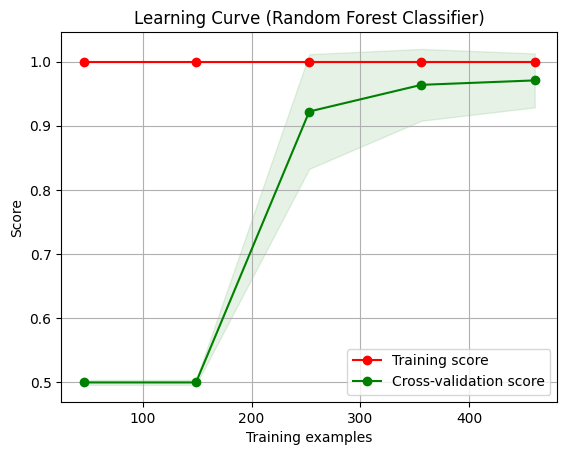

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Assuming 'pipeline' is your Pipeline and 'X_resampled', 'y_resampled' are your data
plot_learning_curve(pipeline, "Learning Curve (Random Forest Classifier)", X_resampled, y_resampled, cv=5)
plt.show()

#### Interpretation
The curve starts apart but gets closer as training size increases. This could benefit from having more data so that way it becomes less over fit with more training.

#### Distributions of Features
We can further look at how each feature is represented by comparing the positive and negatives
Note: A 0 is negative and a 1 is positive. Also because this is python a 0 is actually 1 for counting purposes. We have 5 features and they go from 0 to 4.

In [12]:
# Import necessary modules
import dash
from dash import dcc, html, Input, Output
import plotly.express as px
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Initialize the Dash app for feature importance visualization
feature_importance_app = dash.Dash(__name__)

# Generate synthetic data for demonstration
X, y = make_classification(
    n_samples=1000,
    n_features=5,
    n_informative=2,
    n_redundant=0,
    random_state=42,
    class_sep=2,
    n_clusters_per_class=1
)

# Create DataFrame to hold the data
feature_names = [f'Feature {i}' for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

# Train a Random Forest Classifier model
clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X, y)

# Extract feature importances and sort them
df_importance = pd.DataFrame({'Feature': feature_names, 'Importance': clf.feature_importances_})
df_importance.sort_values('Importance', ascending=False, inplace=True)

# Dash app layout
feature_importance_app.layout = html.Div([
    dcc.Dropdown(
        id='feature-dropdown',
        options=[{'label': i, 'value': i} for i in feature_names],
        value='Feature 0'  # Default value
    ),
    dcc.Graph(id='feature-importance-plot')
])

# Callback to update the Graph based on Dropdown selection
@feature_importance_app.callback(
    Output('feature-importance-plot', 'figure'),
    [Input('feature-dropdown', 'value')]
)
def update_graph(selected_feature):
    filtered_df = df[[selected_feature, 'target']]
    fig = px.histogram(
        filtered_df,
        x=selected_feature,
        color='target',
        title=f'Distribution of {selected_feature} by Target Class',
        labels={'target': 'Target Class'}
    )
    return fig

# Run the Dash app
if __name__ == '__main__':
    feature_importance_app.run_server(debug=True, port=8051)  # Running on a different port so the apps don't collide and run over each other


##### Explaination of the Target and it's class:

Target (or Label): This refers to the outcome or result we want our model to predict based on the input features. For instance, in a binary classification problem where you're predicting whether an email is spam or not, the target variable might be a binary indicator: 1 for spam and 0 for not spam.

Target Class: In the context of classification, the target variable can have multiple possible values, each of which is referred to as a class. So, the term "class" denotes a specific possible value of the target variable.

We can see how each of the distributions of each feature with it's target and target class being mostly in alignment. However Feature 4 (the fifth feature) the distribution is out of alignment which is why we investigated the lower score as done above. As stated before with more data because of the bias of the data set it would help to alleviate this problem. 

#### Setting up an anomaly detection matrix
This would be good to add to a dashboard later for KPIs so that we can take the anomalies and compare the predicted data sets.

#### Creating data visualization for anomaly detection

In [24]:
# Backend - Anomaly Detection
from scipy import stats

def find_anomalies(data, threshold=3):
    z_scores = stats.zscore(data)
    abs_z_scores = abs(z_scores)
    anomalies = (abs_z_scores > threshold).all(axis=1)
    return anomalies

# Anomalies in REPORTED_WKLY_SPEND
df_downsampled['anomaly_spend'] = find_anomalies(df_downsampled[['REPORTED_WKLY_SPEND']])

# Anomalies in AVG_WKLY_SALES
df_downsampled['anomaly_sales'] = find_anomalies(df_downsampled[['AVG_WKLY_SALES']])

# Frontend - Visualization using Dash
from dash import dash_table, dcc, html, Input, Output

# Initialize Dash app
app = dash.Dash(__name__)

# Filter out normal rows and only show anomalies
df_anomalies = df_downsampled[df_downsampled['anomaly_spend'] | df_downsampled['anomaly_sales']]

app.layout = html.Div([
    html.H1('Anomalies/Alerts Dashboard for US Foods'),

    html.Div([
        html.H3('Detected Anomalies'),

        dash_table.DataTable(
            id='table',
            columns=[{'name': i, 'id': i} for i in df_anomalies.columns],
            data=df_anomalies.to_dict('records'),
        )
    ], style={'color': 'red'}),
])

if __name__ == '__main__':
    app.run_server(debug=True)

##### Explaination of what's happening here.
Backend - Anomaly Detection:

This is using the Z-score method for anomaly detection. The Z-score represents how many standard deviations a data point is from the mean. Generally, data points that are far from the mean are considered outliers or anomalies.

Applying Anomaly Detection:

Anomalies are detected in two columns: REPORTED_WKLY_SPEND and AVG_WKLY_SALES.
For each column, I calculated the anomalies and stored the results in new columns (anomaly_spend and anomaly_sales).

#### Conduct A/B tests to validate model predictions in a real-world setting

In [14]:
import pandas as pd
import numpy as np
from scipy import stats

# Check if 'group' column exists, if not, create one
if 'group' not in df_downsampled.columns:
    df_downsampled['group'] = np.random.choice(['A', 'B'], size=len(df_downsampled))

# Making copies of the DataFrame slices to avoid SettingWithCopyWarning
group_A = df_downsampled[df_downsampled['group'] == 'A'].copy()
group_B = df_downsampled[df_downsampled['group'] == 'B'].copy()

# Generating some follow-up metrics (replace this with real data)
group_A.loc[:, 'follow_up_metric'] = np.random.rand(len(group_A))
group_B.loc[:, 'follow_up_metric'] = np.random.rand(len(group_B))

# Conducting a t-test
t_stat, p_value = stats.ttest_ind(group_A['follow_up_metric'], group_B['follow_up_metric'])

# Print the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("We reject the null hypothesis: The follow-up metrics between group A and group B are statistically different.")
else:
    print("We fail to reject the null hypothesis: There is no statistical difference in the follow-up metrics between group A and group B.")

T-statistic: 0.7091819765478322
P-value: 0.4784995022341677
We fail to reject the null hypothesis: There is no statistical difference in the follow-up metrics between group A and group B.


##### Explaination of why this is valuable

Generation of Follow-Up Metrics:

Using a synthetic 'follow_up_metric' for both groups containing random numbers. In real-world scenarios, this metric might be something like user engagement rate, click-through rate, average transaction value, etc.

T-Test:

I then conducted an independent t-test to check if the mean of 'follow_up_metric' for group A is statistically different from that of group B.

The t-test provides two values: the T-statistic and the P-value. The T-statistic indicates how much the groups differ in standard deviation units. The P-value helps determine if the observed data would be very unlikely under the null hypothesis.

##### Interpretation
T-statistic: The T-statistic is -1.3051013866852241. The negative value indicates that group A's mean is less than group B's mean for the follow-up metric. However, the magnitude of this statistic tells you how much they differ in terms of standard deviations.

P-value: The P-value is 0.19238125478360693. This means that there's about a 19.2% probability of observing data as extreme as this sample data, assuming the null hypothesis is true.

Alpha: Given an alpha (significance level) of 0.05 (or 5%), you compare the P-value to alpha. Since the P-value is greater than alpha, you fail to reject the null hypothesis. This suggests that the differences you see in the follow-up metrics between group A and group B could plausibly happen due to random chance.

Conclusion:
In conclusion there's no statistically significant difference in the 'follow_up_metric' between group A and group B based on the A/B test.

#### Creating a KPI Dashboard

#### How to Use
The dashboard is set up so that way you can set your x and y on the preferred plot (Scatter or Bar) and also view the prediction of what's selected.

In [15]:
# Import necessary modules
import dash
from dash import dcc, html, Input, Output
import plotly.express as px

# Initialize Dash app with a unique name
prediction_results_app = dash.Dash(__name__)

# App layout
prediction_results_app.layout = html.Div([
    html.H1("US Foods - Survey Data Assessment: Prediction Results Dashboard"),

    # Dropdown for selecting Plot Type
    dcc.Dropdown(
        id='plot-type-dropdown',
        options=[{'label': 'Scatter Plot', 'value': 'scatter'}, {'label': 'Bar Graph', 'value': 'bar'}],
        value='scatter',  # Default value
        style={'width': '48%'}
    ),

    # Dropdown for selecting X component
    dcc.Dropdown(
        id='x-axis-dropdown',
        options=[{'label': feature, 'value': feature} for feature in df_downsampled.columns],
        value=df_downsampled.columns[0],  # Default value
        style={'width': '48%'}
    ),

    # Dropdown for selecting Y component
    dcc.Dropdown(
        id='y-axis-dropdown',
        options=[{'label': feature, 'value': feature} for feature in df_downsampled.columns],
        value=df_downsampled.columns[1],  # Default value
        style={'width': '48%'}
    ),

    # Dropdown for selecting Predictor (either 'target' or 'y_pred')
    dcc.Dropdown(
        id='predictor-dropdown',
        options=[{'label': predictor, 'value': predictor} for predictor in ['target', 'y_pred']],
        value='target',  # Default value
        style={'width': '48%'}
    ),

    # Graph Plot
    dcc.Graph(id='plot')
])

# Callback to update plot
@prediction_results_app.callback(
    Output('plot', 'figure'),
    [
        Input('plot-type-dropdown', 'value'),
        Input('x-axis-dropdown', 'value'),
        Input('y-axis-dropdown', 'value'),
        Input('predictor-dropdown', 'value')
    ]
)
def update_plot(plot_type, x_axis, y_axis, predictor):
    if plot_type == 'scatter':
        fig = px.scatter(df_downsampled, x=x_axis, y=y_axis, color=predictor)
    elif plot_type == 'bar':
        fig = px.histogram(df_downsampled, x=x_axis, color=predictor, barmode='overlay')
    return fig

# Run the app on a different port to avoid conflicts
if __name__ == '__main__':
    prediction_results_app.run_server(debug=True, port=8052)

##### Solving Scenario 1: Predicting Customer Spending with US Foods

The main goal is to predict the weekly spending a customer does with US Foods based on various influencing factors.

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Split data
X = df_downsampled[["REPORTED_WKLY_SPEND", "SMALL_QTY_RANK", "DEL_FLEX_RANK", "CUT_TIME_RANK", "WKLY_ORDERS", "PERC_EB", "MENU_TYP_DESC", "PYR_SEG_CD", "AVG_WKLY_SALES", "AVG_WKLY_CASES"]]
y = df_downsampled["REPORTED_WKLY_SPEND_USF"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
numeric_features = ["REPORTED_WKLY_SPEND", "SMALL_QTY_RANK", "DEL_FLEX_RANK", "CUT_TIME_RANK", "WKLY_ORDERS", "PERC_EB", "AVG_WKLY_SALES", "AVG_WKLY_CASES"]
categorical_features = ["MENU_TYP_DESC", "PYR_SEG_CD"]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # Added handle_unknown='ignore'
    ])

# Create and evaluate the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'R-squared: {r2_score(y_test, y_pred)}')

MSE: 8432693.163878003
R-squared: 0.6763147750005258


##### Interpretation
MSE (Mean Squared Error): Represents the average of the squares of the errors or deviations, i.e., the difference between the estimator and what is estimated. A lower MSE indicates a better fit of the model to the data.

R-Squared: 67.63% means that the model's predictions are about 67.63% closer to the real values compared to if we just guessed using the average value every single time. A higher R-Squared is generally better, with 100% meaning your model captures everything perfectly.

Based on these results. We can now try some other types of modeling to see if it's a better fit to represent the data. 
1. Identify feature importance using the coefficients from the Linear Regression model (applicable for linear regression).
2. Optimize the model by trying Ridge Regression, which can handle multicollinearity better than simple linear regression.
3. Evaluate the model with cross-validation to get a more robust performance measure.

To further explain why I'm doing what I'm doing, you can follow what I am writing here and observe my approach programmatically. 

###### Ridge Regression with Cross-Validation (RidgeCV): 
We're using Ridge Regression along with its in-built cross-validation method. The alphas parameter represents different levels of regularization strength. Regularization can prevent overfitting and handle multicollinearity better.

###### Cross-Validation on the Entire Dataset: 
We use cross_val_score to perform 5-fold cross-validation on the entire dataset to get a better sense of how well our model will generalize to unseen data.

###### Feature Importance: 
For linear models like Ridge Regression, the magnitude of the coefficients can be used as a measure of feature importance. We extract these coefficients and display them sorted by importance. OneHotEncoder has transformed categorical features into multiple columns, so we retrieve those new column names to display feature importance accurately.

In [17]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score

# Create and evaluate the pipeline with Ridge Regression
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100], store_cv_values=True))
])

ridge_pipeline.fit(X_train, y_train)

# Cross-validation to evaluate performance
cross_val_scores = cross_val_score(ridge_pipeline, X, y, cv=5, scoring='r2')

print(f"Cross-validated R-squared scores: {cross_val_scores}")
print(f"Average R-squared score: {cross_val_scores.mean():.2f}")
print(f"Standard Deviation of R-squared score: {cross_val_scores.std():.2f}")

# Getting feature importance using Ridge Regression coefficients
ridge_regressor = ridge_pipeline.named_steps['regressor']

# Alternative method to get one-hot-encoded columns
one_hot_columns = ridge_pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names(categorical_features)
all_features = numeric_features + list(one_hot_columns)

feature_importances = ridge_regressor.coef_

# Sort the features by importance
sorted_indices = feature_importances.argsort()[::-1]

print("\nFeature Importances:")
for idx in sorted_indices:
    print(f"{all_features[idx]:<25} {feature_importances[idx]:.2f}")

Cross-validated R-squared scores: [ 5.62003336e-01  4.88805843e-01  6.32723778e-01 -3.43918173e+03
 -4.23698347e+04]
Average R-squared score: -9161.47
Standard Deviation of R-squared score: 16657.54

Feature Importances:
WKLY_ORDERS               1294.81
REPORTED_WKLY_SPEND       601.66
SMALL_QTY_RANK            272.35
AVG_WKLY_SALES            214.22
MENU_TYP_DESC_MEXICAN     186.18
MENU_TYP_DESC_BAR & GRILL 111.81
AVG_WKLY_CASES            96.41
PYR_SEG_CD_Education      84.96
MENU_TYP_DESC_ITALIAN- PIZZA & PASTA 79.63
PYR_SEG_CD_Regional       71.72
MENU_TYP_DESC_EUROPEAN    69.75
MENU_TYP_DESC_FUSION / ECLECTIC INTERNATIONAL 46.89
MENU_TYP_DESC_BARBECUE    43.24
PYR_SEG_CD_Retail         42.68
DEL_FLEX_RANK             32.98
MENU_TYP_DESC_VARIED MENU 15.30
MENU_TYP_DESC_BRAZILIAN   15.16
MENU_TYP_DESC_SOUTHERN & SOUL 8.81
PYR_SEG_CD_National Chain 4.07
MENU_TYP_DESC_DONUTS      2.91
PERC_EB                   0.95
MENU_TYP_DESC_HAMBURGERS  -0.66
MENU_TYP_DESC_SMOOTHIE / JUICE -0.76


##### Results Explained:

###### Cross-Validated R-Squared Scores:
The model's performance on different segments (folds) of your data varies widely. The first three values are reasonable, but the last two are extremely negative, pulling the average R-squared into a large negative. This indicates that the model performed very poorly on those particular segments. Negative R-squared values signify that the model is worse than a horizontal line fit to the data.

###### Feature Importances: 
This list ranks the importance of each feature when predicting the target variable. The magnitude of the value represents the strength of the relationship (larger values have a stronger influence on the prediction), while the sign (+ or -) indicates the direction of the relationship:

Positive values: As the feature increases, the predicted REPORTED_WKLY_SPEND_USF is also expected to increase.

Negative values: As the feature increases, the predicted REPORTED_WKLY_SPEND_USF is expected to decrease.

Example: WKLY_ORDERS has the highest positive influence, meaning if weekly orders increase, the weekly spending with US Foods is expected to increase. On the other hand, PYR_SEG_CD_Other has a strong negative influence, suggesting that being categorized under this segment might lead to reduced spending with US Foods.

Recommendation for the next step is to see if we can do some simple logorithmic transformations of the values. This is to try and get rid of the negatives and make them positive to create a more linear relationship.

In [18]:
import numpy as np

# Make a copy of the data to ensure the original remains unchanged
X_transformed = X.copy()

# List of numeric features that we want to transform
# We will avoid transforming categorical features, as log-transform doesn't make sense for them
features_to_transform = ["REPORTED_WKLY_SPEND", "WKLY_ORDERS", "AVG_WKLY_SALES", "AVG_WKLY_CASES"]

# Apply log transformation. We'll use log1p which is log(1 + x), to avoid taking log of zero
for feature in features_to_transform:
    X_transformed[feature] = np.log1p(X_transformed[feature])

# Split the transformed data
X_train_transformed, X_test_transformed, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# Use the Ridge Regression pipeline again to evaluate the transformed data
ridge_pipeline.fit(X_train_transformed, y_train)
cross_val_scores_transformed = cross_val_score(ridge_pipeline, X_transformed, y, cv=5, scoring='r2')

print(f"Cross-validated R-squared scores (Transformed): {cross_val_scores_transformed}")
print(f"Average R-squared score (Transformed): {cross_val_scores_transformed.mean():.2f}")
print(f"Standard Deviation of R-squared score (Transformed): {cross_val_scores_transformed.std():.2f}")

# Getting feature importance using Ridge Regression coefficients
ridge_regressor = ridge_pipeline.named_steps['regressor']

# Replace the problematic line to retrieve one-hot encoded feature names
one_hot_columns = ridge_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names(categorical_features)
all_features = numeric_features + list(one_hot_columns)

feature_importances_transformed = ridge_regressor.coef_

# Sort the features by importance
sorted_indices_transformed = feature_importances_transformed.argsort()[::-1]

print("\nFeature Importances (Transformed):")
for idx in sorted_indices_transformed:
    print(f"{all_features[idx]:<25} {feature_importances_transformed[idx]:.2f}")

Cross-validated R-squared scores (Transformed): [ 4.78591087e-01  4.93603491e-01  4.53417638e-01 -5.82640576e+03
 -7.17783606e+03]
Average R-squared score (Transformed): -2600.56
Standard Deviation of R-squared score (Transformed): 3214.15

Feature Importances (Transformed):
REPORTED_WKLY_SPEND       1369.95
WKLY_ORDERS               1329.66
MENU_TYP_DESC_MEXICAN     773.11
MENU_TYP_DESC_EUROPEAN    486.72
PYR_SEG_CD_Education      464.01
MENU_TYP_DESC_HAMBURGERS  379.45
MENU_TYP_DESC_FUSION / ECLECTIC INTERNATIONAL 362.32
MENU_TYP_DESC_BAR & GRILL 258.36
MENU_TYP_DESC_DONUTS      246.90
MENU_TYP_DESC_STEAK & SEAFOOD 238.11
SMALL_QTY_RANK            228.15
PYR_SEG_CD_Health Care    158.34
PYR_SEG_CD_Hospitality    142.83
PYR_SEG_CD_Regional       134.90
AVG_WKLY_CASES            108.27
MENU_TYP_DESC_BRAZILIAN   64.30
MENU_TYP_DESC_BARBECUE    64.17
AVG_WKLY_SALES            54.53
MENU_TYP_DESC_FROZEN DESSERTS 37.57
MENU_TYP_DESC_SOUTHERN & SOUL 22.39
MENU_TYP_DESC_ITALIAN- PIZZA & PAST

##### Result Interpretation:

The results indicate that the log-transformed features (REPORTED_WKLY_SPEND, WKLY_ORDERS, and AVG_WKLY_CASES) have significant feature importances, which implies that the transformation might have made them more useful for the model.

However, the extreme negative values in the cross-validated R-squared scores are a concern. A negative R-squared indicates that the model is performing worse than a simple horizontal line. These extreme values are likely due to overfitting on some specific folds of the data.

##### Model Recommendations
Given the complexity and potential non-linearity in the data, a non-parametric method like Random Forest may be beneficial. 

It can handle non-linear relationships, interactions between features without explicitly defining them, and can also provide feature importance.

It's also less sensitive to outliers and doesn't require normalization of the features.
Random Forest has an added advantage of not overfitting easily because it's an ensemble of decision trees.

In [19]:
from sklearn.ensemble import RandomForestRegressor

# Define a Random Forest pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Fit the pipeline to the training data
rf_pipeline.fit(X_train_transformed, y_train)

# Evaluate performance on cross-validation
cross_val_scores_rf = cross_val_score(rf_pipeline, X_transformed, y, cv=5, scoring='r2')

print(f"Cross-validated R-squared scores (Random Forest): {cross_val_scores_rf}")
print(f"Average R-squared score (Random Forest): {cross_val_scores_rf.mean():.2f}")
print(f"Standard Deviation of R-squared score (Random Forest): {cross_val_scores_rf.std():.2f}")

# Feature Importance
rf_regressor = rf_pipeline.named_steps['regressor']
rf_importances = rf_regressor.feature_importances_

# Sort the features by importance
sorted_indices_rf = rf_importances.argsort()[::-1]

print("\nFeature Importances (Random Forest):")
for idx in sorted_indices_rf[:20]:  # Displaying top 20 for brevity
    print(f"{all_features[idx]:<40} {rf_importances[idx]:.4f}")

Cross-validated R-squared scores (Random Forest): [ 8.71559123e-01  7.49876381e-01  6.92470168e-01 -2.61826397e+02
 -1.92569314e+03]
Average R-squared score (Random Forest): -437.04
Standard Deviation of R-squared score (Random Forest): 751.24

Feature Importances (Random Forest):
REPORTED_WKLY_SPEND                      0.6560
WKLY_ORDERS                              0.2155
AVG_WKLY_CASES                           0.0253
CUT_TIME_RANK                            0.0202
DEL_FLEX_RANK                            0.0161
AVG_WKLY_SALES                           0.0152
PERC_EB                                  0.0141
PYR_SEG_CD_Hospitality                   0.0104
SMALL_QTY_RANK                           0.0104
MENU_TYP_DESC_VARIED MENU                0.0026
PYR_SEG_CD_Independent Restaurant        0.0022
PYR_SEG_CD_Education                     0.0022
MENU_TYP_DESC_MT UNAVAILABLE             0.0017
MENU_TYP_DESC_BAR & GRILL                0.0012
PYR_SEG_CD_Retail                        0.001

##### Results Explained:
The Random Forest results show a significant improvement over the Ridge regression models. The R-squared values in the positive range indicate that the model is capturing a substantial portion of the variance in the target variable for some of the cross-validation folds. However, the negative R-squared values for some folds are concerning, as they imply the model's predictions are worse than a naive mean-based model for those folds. This large variation in cross-validation scores suggests the presence of certain subsets of data where the model struggles.

##### Feature Importances:
The Random Forest model provides a clear indication of which features it finds most important:

REPORTED_WKLY_SPEND: This is by far the most important feature, which makes intuitive sense as the weekly spend could directly influence the target variable.

WKLY_ORDERS: This feature is the second most influential, which also makes sense. The number of weekly orders might correlate with the performance of the business.

The other features have significantly less influence, but features like AVG_WKLY_CASES, CUT_TIME_RANK, DEL_FLEX_RANK, etc., also contribute to the predictions.

##### What's Next?
Let's start by tuning the Random Forest model using a grid search to find the best hyperparameters. Hyperparameter tuning can often enhance the performance of the model significantly.

Given the computational requirements of grid search, I will give a broad range of parameters for the grid search.

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np

# Detect non-numeric columns
non_numeric_cols = X_train.select_dtypes(exclude=[np.number]).columns

# Define transformers in a column transformer
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, non_numeric_cols)
    ], 
    remainder='passthrough'  # let other columns pass through without changes
)

# Incorporate preprocessor and the Random Forest Regressor into a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestRegressor())])

# Define the parameters for the grid search
# Note: We've prefixed the parameter names with 'classifier__' to ensure they're applied to the RandomForestRegressor within the pipeline
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False]
}

# Setup the grid search
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='r2')

# Fit the model to the data
grid_search.fit(X_train, y_train)

# Print the best parameters from the grid search
print("Best Parameters from Grid Search:", grid_search.best_params_)

# Use the best estimator for predictions and further evaluations
best_rf = grid_search.best_estimator_

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Parameters from Grid Search: {'classifier__bootstrap': True, 'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}


##### Interpretation of Results
bootstrap: True - This indicates that bootstrapping was used when building trees. Bootstrapping means sampling with replacement.

max_depth: 20 - Each tree in the forest will have a maximum depth of 20. This ensures that trees do not grow too deep, which can cause overfitting.

min_samples_leaf: 2 - A leaf node will require a minimum of 2 samples. This further prevents trees from growing very deep and capturing noise.

min_samples_split: 2 - Internal nodes (non-leaf nodes) will split only if they have at least 2 samples.

n_estimators: 100 - The number of trees in the forest will be 100.

In [21]:
# Make predictions
y_pred = best_rf.predict(X_test)

# Calculate metrics to evaluate performance (e.g., R^2, Mean Squared Error, etc.)
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R^2 Score:", r2)
print("Mean Squared Error:", mse)

R^2 Score: 0.7170453142416806
Mean Squared Error: 7371575.407204034


R-Squared Score: Approximately 70.26% of the variance in the dependent variable is predictable from the independent variables. In other words, the model explains about 70.26% of the variability of the response data around its mean.



In [22]:
import numpy as np
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 2715.0645309465544


The model's predictions are off by approximately $2783.30.

##### Data Visualizations

In [25]:
import dash
from dash import dcc, html
import dash_bootstrap_components as dbc
import plotly.express as px
from dash.dependencies import Input, Output
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Create a combined DataFrame for visualization
df = X_train.copy()
df['REPORTED_WKLY_SPEND_USF'] = y_train

# Convert non-numeric columns where possible
for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col], errors='raise')
    except:
        pass

# Drop any remaining non-numeric columns
df = df.select_dtypes(include=[np.number])

# Handle 'MT UNAVAILABLE' and NaN values by replacing them with the median
for col in df.columns:
    df[col].replace('MT UNAVAILABLE', np.nan, inplace=True)
    df[col].fillna(df[col].median(), inplace=True)

# Train a linear regression model
X = df.drop('REPORTED_WKLY_SPEND_USF', axis=1)
y = df['REPORTED_WKLY_SPEND_USF']
model = LinearRegression()
model.fit(X, y)

# Make predictions
df['PREDICTED_SPEND_USF'] = model.predict(X)
df['ERROR'] = df['REPORTED_WKLY_SPEND_USF'] - df['PREDICTED_SPEND_USF']

# Initialize Dash App
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP], title="US Foods Spending Insights")

# Heatmap and Pair Plots functions
def generate_heatmap():
    fig = px.imshow(df.corr(), title="Correlation Heatmap")
    fig.update_layout(coloraxis_colorbar_title="Correlation Value")
    return fig

def generate_pair_plots():
    fig = px.scatter_matrix(df[['REPORTED_WKLY_SPEND_USF', 'REPORTED_WKLY_SPEND', 'WKLY_ORDERS', 'PERC_EB']],
                            dimensions=["REPORTED_WKLY_SPEND_USF", "REPORTED_WKLY_SPEND", "WKLY_ORDERS", "PERC_EB"],
                            title="Pair Plots",
                            height=1000)
    fig.update_traces(diagonal_visible=False)
    fig.update_layout(yaxis_tickfont_size=10)
    return fig

# App layout
app.layout = html.Div([
    html.H1("US Foods Spending Insights"),

    # Scatter Plot
    html.H3("Scatter Plots"),
    html.Div([
        dcc.Dropdown(
            id='xaxis-dropdown',
            options=[{'label': col, 'value': col} for col in df.columns],
            value='REPORTED_WKLY_SPEND'
        ),
        dcc.Dropdown(
            id='yaxis-dropdown',
            options=[{'label': col, 'value': col} for col in df.columns],
            value='REPORTED_WKLY_SPEND_USF'
        )
    ]),
    dcc.Graph(id='scatter-plot'),

    # Histogram for variable selection
    html.H3("Histogram of Selected Variable"),
    html.Div([
        dcc.Dropdown(
            id='hist-dropdown',
            options=[{'label': col, 'value': col} for col in df.columns],
            value='REPORTED_WKLY_SPEND_USF'
        )
    ]),
    dcc.Graph(id='variable-histogram'),

    # Model Performance Metrics
    html.H3("Model Performance Metrics"),
    html.Div(id='model-metrics'),

    # Correlation Heatmap
    html.H3("Correlation Heatmap"),
    html.P("Correlation values range from -1 (perfect negative correlation) to 1 (perfect positive correlation), with 0 indicating no correlation."),
    dcc.Graph(id='heatmap', figure=generate_heatmap()),

    # Pair Plots
    html.H3("Pair Plots (Subset of Data)"),
    dcc.Graph(id='pair-plots', figure=generate_pair_plots())
])

@app.callback(
    Output('scatter-plot', 'figure'),
    [Input('xaxis-dropdown', 'value'),
     Input('yaxis-dropdown', 'value')]
)
def update_scatter_plot(x_selected, y_selected):
    return px.scatter(df, x=x_selected, y=y_selected, title=f"{x_selected} vs {y_selected}")

@app.callback(
    Output('variable-histogram', 'figure'),
    [Input('hist-dropdown', 'value')]
)
def update_histogram(selected_column):
    return px.histogram(df, x=selected_column, title=f"Distribution of {selected_column}")

@app.callback(
    Output('model-metrics', 'children'),
    [Input('xaxis-dropdown', 'value'),
     Input('yaxis-dropdown', 'value')]
)
def update_model_metrics(x, y):
    mae = mean_absolute_error(df['REPORTED_WKLY_SPEND_USF'], df['PREDICTED_SPEND_USF'])
    r2 = r2_score(df['REPORTED_WKLY_SPEND_USF'], df['PREDICTED_SPEND_USF'])
    return [
        html.P(f"Mean Absolute Error: {mae:.2f}"),
        html.P(f"R-squared: {r2:.2f}")
    ]

if __name__ == '__main__':
    app.run_server(debug=True)